<a href="https://colab.research.google.com/github/jungry/time_series/blob/main/TimeSeries_Week09_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Google Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_ccf
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ValueWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.statespace.sarimax")

In [4]:
# Load the synthetic data
data = pd.read_csv('/content/drive/Shareddrives/timeseries-datasets/business_data.csv')
data.head(5)

date  advertising_expenditure  product_quality  competition  \
0  2020-06-01              1248.357077         3.584629     3.357787   
1  2020-06-02               930.867849         4.579355     3.560785   
2  2020-06-03              1323.844269         4.657285     4.083051   
3  2020-06-04              1761.514928         4.197723     4.053802   
4  2020-06-05               882.923313         4.838714     1.622331   

   consumer_preferences  market_gain  
0              3.171005  -151.868532  
1              3.439819   -53.691425  
2              4.747294     9.090931  
3              4.610370    15.322909  
4              3.979098   -38.592691

# 1. Data Inspection and Visualization

In [5]:
# Check column names
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     100 non-null    object 
 1   advertising_expenditure  100 non-null    float64
 2   product_quality          100 non-null    float64
 3   competition              100 non-null    float64
 4   consumer_preferences     100 non-null    float64
 5   market_gain              100 non-null    float64
dtypes: float64(5), object(1)
memory usage: 4.8+ KB


In [6]:
# If the data was not into datetime format
data['date'] = pd.to_datetime(data['date'])
#date Ïó¥ÏùÑ datetime ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò -> ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º Îçî Ïûò Ï≤òÎ¶¨Ìï†Ïàò ÏûàÎèÑÎ°ù Ìï® !

In [7]:
# Set 'Date' as index
data = data.set_index('date')

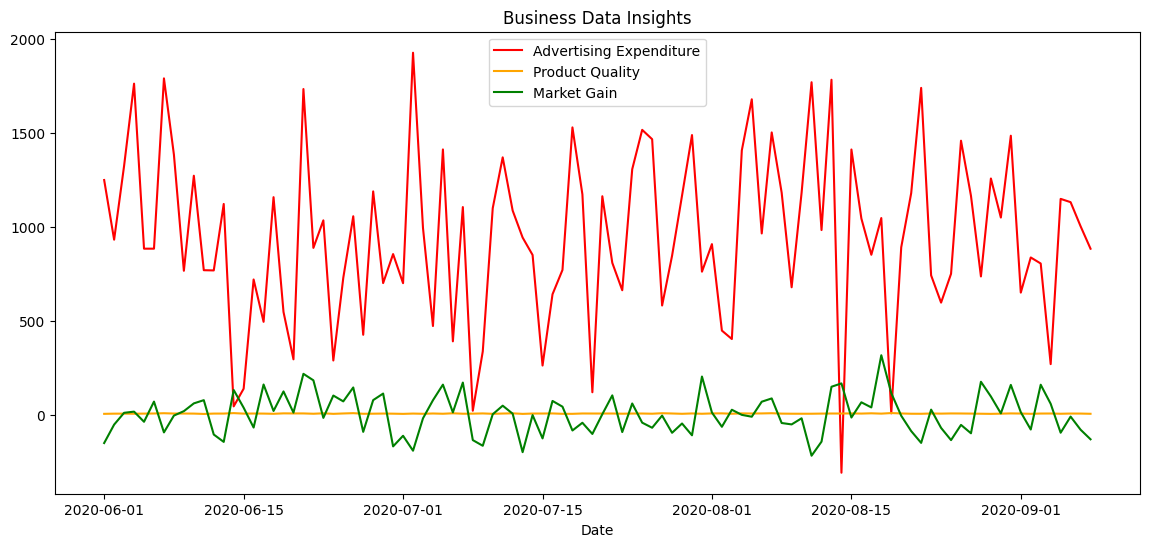

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(data['advertising_expenditure'], label='Advertising Expenditure', color='red')
plt.plot(data['product_quality'], label='Product Quality', color='orange')
#plt.plot(data['competition'], label='Competition', color='blue')
plt.plot(data['market_gain'], label='Market Gain', color='green')
plt.legend()
plt.title('Business Data Insights')
plt.xlabel('Date')
plt.show()

# 2. Stationarity Check with Augmented Dickey-Fuller Test

#### **Recap**
**Definition:** A stationary series has constant mean, variance, and autocorrelation over time, unlike a non-stationary series, which shows trends or changing variance.<br>
**Importance:** Stationarity is key for accurate forecasting in models like ARIMA, as it ensures stable patterns for reliable predictions.<br>
**ADF Test for Stationarity:**
   * **Purpose:** Determines if a series is stationary or has a trend (unit root).
   * **Interpretation:**
        * **Test Statistic:** More negative than critical values (at 1%, 5%, or 10%) suggests stationarity.
        * **p-value:** Less than 0.05 indicates stationarity; higher implies non-stationarity.

Ï†ïÏùò: Ï†ïÏÉÅ(stationary) ÏãúÍ≥ÑÏó¥ÏùÄ ÏãúÍ∞ÑÏóê Îî∞Îùº ÌèâÍ∑†, Î∂ÑÏÇ∞ Î∞è ÏûêÍ∏∞ÏÉÅÍ¥ÄÏù¥ ÏùºÏ†ïÌïú ÏãúÍ≥ÑÏó¥ÏùÑ ÏùòÎØ∏ÌïòÎ©∞, ÎπÑÏ†ïÏÉÅ(non-stationary) ÏãúÍ≥ÑÏó¥ÏùÄ Ìä∏Î†åÎìúÎÇò Î≥ÄÎèôÏÑ± Î≥ÄÌôîÍ∞Ä ÎÇòÌÉÄÎÇòÎäî ÏãúÍ≥ÑÏó¥ÏùÑ ÏùòÎØ∏Ìï®.<br>
Ï§ëÏöîÏÑ±: Ï†ïÏÉÅÏÑ±ÏùÄ ARIMAÏôÄ Í∞ôÏùÄ Î™®Îç∏Ïùò Ï†ïÌôïÌïú ÏòàÏ∏°ÏùÑ ÏúÑÌï¥ ÌïÑÏàòÏ†ÅÏù¥Î©∞, ÏïàÏ†ïÏ†ÅÏù∏ Ìå®ÌÑ¥ÏùÑ Î≥¥Ïû•ÌïòÏó¨ Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî ÏòàÏ∏°ÏùÑ Í∞ÄÎä•ÌïòÍ≤å Ìï®.<br>
ADF Ï†ïÏÉÅÏÑ± Í≤ÄÏ†ï:<br>
Î™©Ï†Å: ÏãúÍ≥ÑÏó¥Ïù¥ Ï†ïÏÉÅÏÑ± Ïó¨Î∂ÄÎ•º Í∞ÄÏßÄÎäîÏßÄ, ÎòêÎäî Ìä∏Î†åÎìú(Îã®ÏúÑÍ∑º)Í∞Ä Ï°¥Ïû¨ÌïòÎäîÏßÄÎ•º ÌåêÎã®.<br>
Ìï¥ÏÑù:<br>
‚Ä¢	Í≤ÄÏ†ï ÌÜµÍ≥ÑÎüâ: 1%, 5%, 10%Ïùò ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ Îçî Î∂ÄÏ†ïÏ†ÅÏù∏ Í∞íÏù¥Î©¥ Ï†ïÏÉÅÏÑ±ÏùÑ ÏãúÏÇ¨Ìï®. <br>
‚Ä¢	p-Í∞í: 0.05 ÎØ∏ÎßåÏù¥Î©¥ Ï†ïÏÉÅÏÑ±ÏùÑ ÎÇòÌÉÄÎÇ¥Î©∞, Îçî ÎÜíÏùÄ Í∞íÏùÄ ÎπÑÏ†ïÏÉÅÏÑ±ÏùÑ ÎÇòÌÉÄÎÉÑ.

In [9]:

#adf_test Ìï®Ïàò Ï†ïÏùò
def adf_test(series): #ÌååÏù¥Ïç¨ÏùÄ Îß§Í∞úÎ≥ÄÏàòÎ•º Ï†ïÏùòÌï†Îïå Îç∞Ïù¥ÌÑ∞ Ïú†Ìòï Ï†ïÌïòÏßÄ ÏïäÏïÑÎèÑ Îê®. Í∑∏ÎûòÏÑú list seriesÍ∞Ä ÏïÑÎãàÎùº Í∑∏ÎÉ• seriesÎùºÍ≥† ÏîÄ.
    result = sm.tsa.adfuller(series) #series Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ ADF Í≤ÄÏ†ï ÏàòÌñâ -> Ï†ïÏÉÅÏÑ± Ïó¨Î∂Ä ÌåêÎã®
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.2f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.2f}')

"""
sm.tsa.adfuller : ADFÍ≤ÄÏ†ïÏùÑ ÏàòÌñâÌïòÏó¨ Í≤∞Í≥ºÎ•º Î∞òÌôòÌïòÎäî Ìï®Ïàò
  ‚Ä¢	result[0]: Í≤ÄÏ†ï ÌÜµÍ≥ÑÎüâ(ADF Statistic)
	‚Ä¢	result[1]: p-value (Ï†ïÏÉÅÏÑ± Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ¥Îäî ÏßÄÌëú)
	‚Ä¢	result[2]: ÏÇ¨Ïö©Îêú Îûô Ïàò
	‚Ä¢	result[3]: Í¥ÄÏ∏°Í∞íÏùò Í∞úÏàò
	‚Ä¢	result[4]: Îã§ÏñëÌïú Ïã†Î¢∞ÏàòÏ§Ä(1%, 5%, 10%)ÏóêÏÑúÏùò ÏûÑÍ≥ÑÍ∞í(critical values)
	‚Ä¢	result[5]: ÏµúÏ†ÅÏùò ADF Î™®Îç∏Ïóê ÎåÄÌïú Ï∂îÍ∞Ä Ï†ïÎ≥¥

"""


'\nsm.tsa.adfuller : ADFÍ≤ÄÏ†ïÏùÑ ÏàòÌñâÌïòÏó¨ Í≤∞Í≥ºÎ•º Î∞òÌôòÌïòÎäî Ìï®Ïàò\n  ‚Ä¢\tresult[0]: Í≤ÄÏ†ï ÌÜµÍ≥ÑÎüâ(ADF Statistic)\n\t‚Ä¢\tresult[1]: p-value (Ï†ïÏÉÅÏÑ± Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ¥Îäî ÏßÄÌëú)\n\t‚Ä¢\tresult[2]: ÏÇ¨Ïö©Îêú Îûô Ïàò\n\t‚Ä¢\tresult[3]: Í¥ÄÏ∏°Í∞íÏùò Í∞úÏàò\n\t‚Ä¢\tresult[4]: Îã§ÏñëÌïú Ïã†Î¢∞ÏàòÏ§Ä(1%, 5%, 10%)ÏóêÏÑúÏùò ÏûÑÍ≥ÑÍ∞í(critical values)\n\t‚Ä¢\tresult[5]: ÏµúÏ†ÅÏùò ADF Î™®Îç∏Ïóê ÎåÄÌïú Ï∂îÍ∞Ä Ï†ïÎ≥¥\n\n'

In [10]:
# Check stationarity of Advertising Expenditure
print("ADF Test for Advertising Expenditure")
print("===========================")
adf_test(data['advertising_expenditure'])

'''
ADF StatisticÏù¥ 1%ÏûÑÍ≥ÑÍ∞íÏù∏ -3.5Î≥¥Îã§ ÏûëÏùå, p-value < 0.06 -> stationary. ('Í∑ÄÎ¨¥Í∞ÄÏÑ§: non-stationary Ïù¥Îã§.' Î•º Í∏∞Í∞Å)
ÏûÑÍ≥ÑÍ∞íÏù¥ 10%ÏóêÏÑú 1%Î°ú Í∞àÏàòÎ°ù Í∏∞Ï§ÄÏù¥ Îçî ÏóÑÍ≤©Ìï¥Ïßê.
1% ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ Îçî ÏûëÎã§ : Îß§Ïö∞ Í∞ïÌïú Ï¶ùÍ±∞Î°ú stationary.
10%ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ ÏûëÎã§: stationaryÌï† Í∞ÄÎä•ÏÑ± ÏûàÏùå.
'''

ADF Test for Advertising Expenditure
ADF Statistic: -10.08
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


"\nADF StatisticÏù¥ 1%ÏûÑÍ≥ÑÍ∞íÏù∏ -3.5Î≥¥Îã§ ÏûëÏùå, p-value < 0.06 -> stationary. ('Í∑ÄÎ¨¥Í∞ÄÏÑ§: non-stationary Ïù¥Îã§.' Î•º Í∏∞Í∞Å)\nÏûÑÍ≥ÑÍ∞íÏù¥ 10%ÏóêÏÑú 1%Î°ú Í∞àÏàòÎ°ù Í∏∞Ï§ÄÏù¥ Îçî ÏóÑÍ≤©Ìï¥Ïßê. \n1% ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ Îçî ÏûëÎã§ : Îß§Ïö∞ Í∞ïÌïú Ï¶ùÍ±∞Î°ú stationary. \n10%ÏûÑÍ≥ÑÍ∞íÎ≥¥Îã§ ÏûëÎã§: stationaryÌï† Í∞ÄÎä•ÏÑ± ÏûàÏùå.\n"

In [11]:
# Check stationarity of Product Quality
print("\nADF Test for Product Quality")
print("==============================")
adf_test(data['product_quality'])


ADF Test for Product Quality
ADF Statistic: -10.88
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


In [12]:
# Check stationarity of Competition
print("\nADF Test for Competition")
print("=======================")
adf_test(data['competition'])


ADF Test for Competition
ADF Statistic: -11.10
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


In [13]:
# Check stationarity of Consumer Preferences
print("\nADF Test for Consumer Preferences")
print("=======================")
adf_test(data['consumer_preferences'])


ADF Test for Consumer Preferences
ADF Statistic: -9.25
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


In [14]:
# Check stationarity of Market Gain
print("\nADF Test for Market Gain")
print("=======================")
adf_test(data['market_gain'])


ADF Test for Market Gain
ADF Statistic: -8.45
p-value: 0.00
Critical Values:
   1%: -3.50
   5%: -2.89
   10%: -2.58


# 3. Exogeneity Tests

**What is Exogeneity?**<br>
In time series analysis, an exogenous variable is one that influences the primary series but is not influenced by it in return. Exogeneity tests help confirm if a variable can act as an independent predictor in forecasting models without feedback from the primary series.

**Why is Exogeneity Important?**<br>
Identifying exogenous variables improves model accuracy by allowing only true independent variables to inform the primary series. Properly identifying exogenous variables helps avoid biases in predictions and enables clearer insights into cause-effect relationships.

## 3.1 Granger Causality Test:

**Purpose:** Checks if past values of one time series can predict future values of another, indicating a directional influence.<br>
**Hypotheses:**
* Null Hypothesis (H‚ÇÄ): The exogenous variable does not Granger-cause the primary series.
* Alternative Hypothesis: The exogenous variable Granger-causes the primary series.

**Interpretation:**<br>
A p-value < 0.05 suggests rejecting the null hypothesis, indicating that the exogenous variable influences the primary series, supporting exogeneity.

**Ïô∏ÏÉùÏÑ± ÌÖåÏä§Ìä∏**

**Ïô∏ÏÉùÏÑ±(Exogeneity)Ïù¥ÎûÄ?**<br>
ÏãúÍ≥ÑÏó¥ Î∂ÑÏÑùÏóêÏÑú Ïô∏ÏÉù Î≥ÄÏàòÎûÄ Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÏßÄÎßå, Í∑∏Ïóê Î∞òÎåÄÏùò ÏòÅÌñ•ÏùÑ Î∞õÏßÄ ÏïäÎäî Î≥ÄÏàòÎ•º ÏùòÎØ∏Ìï®.<br> Ïô∏ÏÉùÏÑ± ÌÖåÏä§Ìä∏Îäî ÌäπÏ†ï Î≥ÄÏàòÍ∞Ä ÏòàÏ∏° Î™®Îç∏ÏóêÏÑú ÎèÖÎ¶ΩÏ†ÅÏù∏ ÏòàÏ∏°ÏûêÎ°ú ÏûëÏö©Ìï† Ïàò ÏûàÎäîÏßÄ, Ï¶â Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïóê ÏùòÌï¥ ÌîºÎìúÎ∞±ÏùÑ Î∞õÏßÄ ÏïäÎäîÏßÄÎ•º ÌôïÏù∏ÌïòÎäî Îç∞ ÎèÑÏõÄÏùÑ Ï§å.<br>

ÏâΩÍ≤å ÎßêÌï¥, Ïô∏ÏÉù Î≥ÄÏàòÎäî Ïñ¥Îñ§ ÏãúÏä§ÌÖúÏù¥ÎÇò ÏãúÍ≥ÑÏó¥Ïóê ÏòÅÌñ•ÏùÑ Ï£ºÏßÄÎßå, Í∑∏ Î∞òÎåÄÎ°ú Í∑∏ ÏãúÏä§ÌÖúÏù¥ÎÇò ÏãúÍ≥ÑÏó¥Ïóê ÏùòÌï¥ ÏòÅÌñ•ÏùÑ Î∞õÏßÄÎäî ÏïäÎäî Î≥ÄÏàò. ÏòàÎ•º Îì§Ïñ¥, ÎÇ†Ïî®Í∞Ä ÏÉÅÌíà ÌåêÎß§ÎüâÏóê ÏòÅÌñ•ÏùÑ Ï§Ñ ÏàòÎäî ÏûàÏßÄÎßå, ÏÉÅÌíà ÌåêÎß§ÎüâÏù¥ ÎÇ†Ïî®Ïóê ÏòÅÌñ•ÏùÑ Ï£ºÏßÄ ÏïäÎäîÎã§Î©¥ ÎÇ†Ïî®Í∞Ä Ïô∏ÏÉù Î≥ÄÏàòÎùºÍ≥† Ìï† Ïàò ÏûàÏùå! Ï¶â, Ïô∏ÏÉù Î≥ÄÏàòÎäî Ï£ºÎ°ú ÎèÖÎ¶ΩÏ†ÅÏù∏ ÏöîÏù∏ÏúºÎ°ú ÏûëÏö©ÌïòÎ©¥ÏÑú Í≤∞Í≥ºÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÏßÄÎßå Í∑∏ Í≤∞Í≥ºÏóê ÏùòÌï¥ Î≥ÄÌôîÌïòÏßÄ ÏïäÎäî Í≤ÉÏùÑ ÏùòÎØ∏ÌïúÎã§~

**Ïôú Ïô∏ÏÉùÏÑ±Ïù¥ Ï§ëÏöîÌïúÍ∞Ä?**<br>
Ïô∏ÏÉù Î≥ÄÏàòÎ•º ÏãùÎ≥ÑÌïòÎ©¥ ÏßÑÏ†ïÌïú ÎèÖÎ¶Ω Î≥ÄÏàòÎ•º Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïóê Î∞òÏòÅÌïòÏó¨ Î™®Îç∏Ïùò Ï†ïÌôïÏÑ±ÏùÑ ÎÜíÏùº Ïàò ÏûàÏùå!<br> Ïô∏ÏÉù Î≥ÄÏàòÎ•º Ï†úÎåÄÎ°ú ÏãùÎ≥ÑÌïòÎ©¥ ÏòàÏ∏°ÏóêÏÑúÏùò Ìé∏Ìñ•ÏùÑ Î∞©ÏßÄÌïòÍ≥† ÏõêÏù∏-Í≤∞Í≥º Í¥ÄÍ≥ÑÎ•º Î™ÖÌôïÌïòÍ≤å Ïù¥Ìï¥Ìï† Ïàò ÏûàÏùå.<br>

**3.1 Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÏÑ± Í≤ÄÏ†ï** (Granger Causality Test)<br>
Î™©Ï†Å:Ìïú ÏãúÍ≥ÑÏó¥Ïùò Í≥ºÍ±∞ Í∞íÏù¥ Îã§Î•∏ ÏãúÍ≥ÑÏó¥Ïùò ÎØ∏Îûò Í∞íÏùÑ ÏòàÏ∏°Ìï† Ïàò ÏûàÎäîÏßÄÎ•º ÌôïÏù∏ÌïòÏó¨ Î∞©Ìñ•ÏÑ±ÏùÑ Í∞ÄÏßÑ ÏòÅÌñ•ÏùÑ ÎÇòÌÉÄÎÇ¥ÎäîÏßÄ Í≤ÄÏÇ¨.<br>

**Í∞ÄÏÑ§**:<br>

‚Ä¢	Í∑ÄÎ¨¥Í∞ÄÏÑ§ (H‚ÇÄ): Ïô∏ÏÉù Î≥ÄÏàòÎäî Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïóê ÎåÄÌï¥ Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÏÑ±ÏùÑ Í∞ÄÏßÄÏßÄ ÏïäÎäîÎã§.<br>
‚Ä¢	ÎåÄÎ¶ΩÍ∞ÄÏÑ§: Ïô∏ÏÉù Î≥ÄÏàòÎäî Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïóê ÎåÄÌï¥ Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÏÑ±ÏùÑ Í∞ÄÏßÑÎã§.<br>

**Ìï¥ÏÑù**:<br>
p-Í∞íÏù¥ 0.05Î≥¥Îã§ ÏûëÏúºÎ©¥ Í∑ÄÎ¨¥Í∞ÄÏÑ§ÏùÑ Í∏∞Í∞ÅÌïòÍ≥† Ïô∏ÏÉù Î≥ÄÏàòÍ∞Ä Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπúÎã§Í≥† Í≤∞Î°†ÏßÄÏñ¥ Ïô∏ÏÉùÏÑ±ÏùÑ ÏßÄÏßÄÌï† Ïàò ÏûàÏùå.<br>

Ïûê ÏòàÏãú Îì§Ïñ¥Í∞ÑÎã§ ~~<br>
ÏÉÅÌô©: AÎùºÎäî ÏãúÍ≥ÑÏó¥(Ïòà: Í≥ºÍ±∞Ïùò Í¥ëÍ≥†ÎπÑ ÏßÄÏ∂ú)Í≥º BÎùºÎäî ÏãúÍ≥ÑÏó¥(Ïòà: ÎØ∏ÎûòÏùò ÌåêÎß§Îüâ)Ïù¥ ÏûàÎã§Í≥† Ìï¥.

	1.	Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÏÑ± Í≤ÄÏ†ïÏùò Î™©Ï†Å: AÏùò Í≥ºÍ±∞ Í¥ëÍ≥†ÎπÑÍ∞Ä BÏùò ÎØ∏Îûò ÌåêÎß§ÎüâÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäîÏßÄ ÏïåÍ≥† Ïã∂Ïñ¥. Ï¶â, ‚ÄúÍ¥ëÍ≥†ÎπÑÍ∞Ä ÎäòÏñ¥ÎÇòÎ©¥ ÌåêÎß§ÎüâÏù¥ Ï¶ùÍ∞ÄÌï†Íπå?‚ÄúÎ•º ÌÖåÏä§Ìä∏ÌïòÎäî Í±∞ÏûÑ.
	2.	Í∞ÄÏÑ§:
	‚Ä¢	Í∑ÄÎ¨¥Í∞ÄÏÑ§ (H‚ÇÄ): ‚ÄúÍ¥ëÍ≥†ÎπÑÍ∞Ä ÌåêÎß§ÎüâÏóê ÏòÅÌñ•ÏùÑ Ï£ºÏßÄ ÏïäÎäîÎã§.‚Äù (Ï¶â, Í¥ëÍ≥†ÎπÑÏôÄ ÌåêÎß§ÎüâÏùÄ Í¥ÄÎ†®Ïù¥ ÏóÜÎã§.)
	‚Ä¢	ÎåÄÎ¶ΩÍ∞ÄÏÑ§: ‚ÄúÍ¥ëÍ≥†ÎπÑÍ∞Ä ÌåêÎß§ÎüâÏóê ÏòÅÌñ•ÏùÑ Ï§ÄÎã§.‚Äù (Ï¶â, Í¥ëÍ≥†ÎπÑÍ∞Ä Ï¶ùÍ∞ÄÌïòÎ©¥ ÌåêÎß§ÎüâÎèÑ Ï¶ùÍ∞ÄÌïúÎã§.)
	3.	ÌÖåÏä§Ìä∏ Í≥ºÏ†ï:
	‚Ä¢	Í≥ºÍ±∞ Í¥ëÍ≥†ÎπÑ Îç∞Ïù¥ÌÑ∞(A)Î•º ÏÇ¨Ïö©Ìï¥ ÌåêÎß§Îüâ Îç∞Ïù¥ÌÑ∞(B)Í∞Ä ÏñºÎßàÎÇò Ïûò ÏòàÏ∏°ÎêòÎäîÏßÄ Î∂ÑÏÑùÌï®.
	‚Ä¢	Í∑∏ÎûúÏ†Ä Í≤ÄÏ†ïÏùÑ ÌÜµÌï¥ p-Í∞íÏùÑ Í≥ÑÏÇ∞Ìï®.
	4.	Ìï¥ÏÑù:
	‚Ä¢	ÎßåÏïΩ p-Í∞íÏù¥ 0.05Î≥¥Îã§ ÏûëÏúºÎ©¥, Í∑ÄÎ¨¥Í∞ÄÏÑ§ÏùÑ Í∏∞Í∞ÅÌï®. Ï¶â, ‚ÄúÍ¥ëÍ≥†ÎπÑÍ∞Ä ÌåêÎß§ÎüâÏóê ÏòÅÌñ•ÏùÑ Ï§ÄÎã§‚ÄùÎäî Í≤∞Î°†ÏùÑ ÎÇ¥Î¶º.
	‚Ä¢	Î∞òÎåÄÎ°ú p-Í∞íÏù¥ 0.05Î≥¥Îã§ ÌÅ¨Î©¥, Í∑ÄÎ¨¥Í∞ÄÏÑ§ÏùÑ Î∞õÏïÑÎì§Ïù¥Í≥† ‚ÄúÍ¥ëÍ≥†ÎπÑÏôÄ ÌåêÎß§ÎüâÏùÄ Í¥ÄÎ†®Ïù¥ ÏóÜÎã§‚ÄùÎäî Í≤∞Î°†ÏùÑ ÎÇ¥Î¶º.

Ïù¥Î†áÍ≤å Ìï¥ÏÑú Ïñ¥Îñ§ Î≥ÄÏàòÍ∞Ä Îã§Î•∏ Î≥ÄÏàòÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäîÏßÄ ÌôïÏù∏Ìï† Ïàò ÏûàÎäî Í±∞ÏûÑ.

### **Syntax:**
```
grangercausalitytests(data, maxlag, addconst=True, verbose=True)
```
**data:** A two-dimensional array-like object (e.g., DataFrame) where the first column is the dependent variable (Y) and the second column is the exogenous variable (X) that might Granger-cause Y.

**maxlag:** The maximum number of lags to test for Granger causality. This is an integer, and the test will go from 1 up to maxlag lags.

**addconst (optional):** A boolean that determines whether a constant should be added to the regression model. Default is True.

**verbose (optional):** A boolean that controls whether to print the test results for each lag. Default is True.


### **How to read:**
**Hypotheses Setup:**
* For a variable ùëã to be considered exogenous relative to another variable ùëå (your primary series), ùëã should Granger-cause ùëå (i.e., influence ùëå), but ùëå should not Granger-cause ùëã.
* Conversely, if ùëå Granger-causes ùëã, then ùëã is likely endogenous to ùëå, meaning they influence each other, or ùëã depends on ùëå.

**Significant Tests:**
* F-test: Tests the significance of the lagged values of the exogenous variable in predicting the dependent variable.
* Chi-squared test: Tests whether lagged values jointly add predictive value.

**Apply Granger Causality Test in Both Directions:**
* Test 1: Does ùëã Granger-cause ùëå ?
    * *Null Hypothesis:* ùëã does not Granger-cause ùëå.
* Test 2: Does ùëå Granger-cause ùëã?
    * *Null Hypothesis:* ùëå does not Granger-cause ùëã.

**Interpret the Results:**
* Exogenous Variable: If the p-value for Test 1 (ùëã ‚Üí ùëå) is less than 0.05 (indicating causality), but the p-value for Test 2 (ùëå ‚Üí ùëã) is greater than 0.05, ùëã can be considered exogenous because it influences ùëå but is not influenced by it.
* Endogenous Variable: If the p-values are both below 0.05, there is mutual causation, suggesting that ùëã and ùëå influence each other. This makes ùëã an endogenous variable in relation to ùëå.

Syntax:
grangercausalitytests(data, maxlag, addconst=True, verbose=True)

data: Îëê Í∞úÏùò Ï∞®ÏõêÏùÑ Í∞ÄÏßÑ Î∞∞Ïó¥ Í∞ôÏùÄ Í∞ùÏ≤¥(Ïòà: DataFrame)Î°ú, Ï≤´ Î≤àÏß∏ Ïó¥ÏùÄ Ï¢ÖÏÜç Î≥ÄÏàò(Y)Ïù¥Í≥† Îëê Î≤àÏß∏ Ïó¥ÏùÄ YÏóê ÎåÄÌï¥ Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÏÑ±ÏùÑ Í∞ÄÏßà Ïàò ÏûàÎäî Ïô∏ÏÉù Î≥ÄÏàò(X)ÏûÑ.

maxlag: Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÏÑ± Í≤ÄÏ†ïÏùÑ ÏúÑÌïú ÏµúÎåÄ ÏßÄÏó∞ Ïàò. Ï†ïÏàòÌòïÏù¥Î©∞, ÌÖåÏä§Ìä∏Îäî 1Î∂ÄÌÑ∞ maxlagÍπåÏßÄÏùò ÏßÄÏó∞ÏùÑ Í≤ÄÏÇ¨Ìï®.

addconst (ÏÑ†ÌÉùÏ†Å): ÌöåÍ∑Ä Î™®Îç∏Ïóê ÏÉÅÏàòÎ•º Ï∂îÍ∞ÄÌï†ÏßÄ Ïó¨Î∂ÄÎ•º Í≤∞Ï†ïÌïòÎäî Î∂àÎ¶¨Ïñ∏. Í∏∞Î≥∏Í∞íÏùÄ True.

verbose (ÏÑ†ÌÉùÏ†Å): Í∞Å ÏßÄÏó∞Ïóê ÎåÄÌïú ÌÖåÏä§Ìä∏ Í≤∞Í≥ºÎ•º Ï∂úÎ†•Ìï†ÏßÄ Ïó¨Î∂ÄÎ•º Ï†úÏñ¥ÌïòÎäî Î∂àÎ¶¨Ïñ∏. Í∏∞Î≥∏Í∞íÏùÄ True.

ÏùΩÎäî Î∞©Î≤ï:

Í∞ÄÏÑ§ ÏÑ§Ï†ï:

Î≥ÄÏàò ùëãÍ∞Ä Îã§Î•∏ Î≥ÄÏàò ùëå(Ï£ºÏöî ÏãúÍ≥ÑÏó¥)Ïóê ÎåÄÌï¥ Ïô∏ÏÉù Î≥ÄÏàòÎ°ú Í∞ÑÏ£ºÎêòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî ùëãÍ∞Ä ùëåÎ•º Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÌï¥Ïïº(Ï¶â, ùëåÏóê ÏòÅÌñ•ÏùÑ ÎØ∏Ï≥êÏïº ÌïòÎ©∞), ùëåÎäî ùëãÎ•º Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÌïòÏßÄ ÏïäÏïÑÏïº Ìï®.
Î∞òÎåÄÎ°ú, ùëåÍ∞Ä ùëãÎ•º Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÌïòÎ©¥ ùëãÎäî ùëåÏóê ÎåÄÌï¥ ÎÇ¥ÏÉùÏ†ÅÏùº Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏúºÎ©∞, Ïù¥Îäî Îëê Î≥ÄÏàòÍ∞Ä ÏÑúÎ°ú ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÍ±∞ÎÇò ùëãÍ∞Ä ùëåÏóê ÏùòÏ°¥Ìï®ÏùÑ ÏùòÎØ∏Ìï®.

Ïú†ÏùòÎØ∏Ìïú ÌÖåÏä§Ìä∏:

F-test: Ï¢ÖÏÜç Î≥ÄÏàòÎ•º ÏòàÏ∏°ÌïòÎäî Îç∞ ÏûàÏñ¥ Ïô∏ÏÉù Î≥ÄÏàòÏùò ÏßÄÏó∞ Í∞íÏùò Ïú†ÏùòÏÑ±ÏùÑ ÌÖåÏä§Ìä∏Ìï®.
Chi-squared test: ÏßÄÏó∞ Í∞íÎì§Ïù¥ Í≥µÎèôÏúºÎ°ú ÏòàÏ∏° Í∞ÄÏπòÎ•º Ï∂îÍ∞ÄÌïòÎäîÏßÄÎ•º ÌÖåÏä§Ìä∏Ìï®.

Ïñë Î∞©Ìñ•ÏúºÎ°ú Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÏÑ± Í≤ÄÏ†ï Ï†ÅÏö©:

ÌÖåÏä§Ìä∏ 1: ùëãÍ∞Ä ùëåÎ•º Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÌïòÎäîÍ∞Ä?<br>
Í∑ÄÎ¨¥Í∞ÄÏÑ§: ùëãÎäî ùëåÎ•º Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÌïòÏßÄ ÏïäÎäîÎã§.<br>
ÌÖåÏä§Ìä∏ 2: ùëåÍ∞Ä ùëãÎ•º Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÌïòÎäîÍ∞Ä?<br>
Í∑ÄÎ¨¥Í∞ÄÏÑ§: ùëåÎäî ùëãÎ•º Í∑∏ÎûúÏ†Ä Ïù∏Í≥ºÌïòÏßÄ ÏïäÎäîÎã§.<br>

Í≤∞Í≥º Ìï¥ÏÑù:

Ïô∏ÏÉù Î≥ÄÏàò: ÌÖåÏä§Ìä∏ 1(ùëã ‚Üí ùëå)Ïùò p-Í∞íÏù¥ 0.05 ÎØ∏Îßå(Ïù∏Í≥ºÏÑ±ÏùÑ ÎÇòÌÉÄÎÉÑ)Ïù¥ÏßÄÎßå, ÌÖåÏä§Ìä∏ 2(ùëå ‚Üí ùëã)Ïùò p-Í∞íÏù¥ 0.05Î≥¥Îã§ ÌÅ¨Î©¥, ùëãÎäî ùëåÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÏßÄÎßå ùëåÏóê ÏùòÌï¥ ÏòÅÌñ•ÏùÑ Î∞õÏßÄ ÏïäÏúºÎØÄÎ°ú Ïô∏ÏÉù Î≥ÄÏàòÎ°ú Í∞ÑÏ£ºÎê† Ïàò ÏûàÏùå.

ÎÇ¥ÏÉù Î≥ÄÏàò: p-Í∞íÏù¥ Î™®Îëê 0.05 ÎØ∏ÎßåÏù¥Î©¥ ÏÉÅÌò∏ Ïù∏Í≥ºÏÑ±Ïù¥ ÏûàÏúºÎ©∞, ùëãÏôÄ ùëåÍ∞Ä ÏÑúÎ°ú ÏòÅÌñ•ÏùÑ ÎØ∏ÏπúÎã§Í≥† Ï†úÏïàÌï®. Ïù¥Îäî ùëãÍ∞Ä ùëåÏóê ÎåÄÌï¥ ÎÇ¥ÏÉù Î≥ÄÏàòÏûÑÏùÑ ÏùòÎØ∏Ìï®.

In [26]:
# Test if advertising_expenditure Granger->causes market_gain
print("\nGranger Causality Test: Advertising Expenditure -> Market Gain")
granger_test_1a = grangercausalitytests(data[['advertising_expenditure', 'market_gain']], maxlag=2) #ÏûêÎèôÏ∂úÎ†•ÎêòÎäî Ìï®ÏàòÏûÑ
print("=====================================================================================")

# Test if market_gain Granger->causes advertising_expenditure
print("\nGranger Causality Test: Market Gain -> Advertising Expenditure")
granger_test_1b = grangercausalitytests(data[['market_gain', 'advertising_expenditure']], maxlag=2)


Granger Causality Test: Advertising Expenditure -> Market Gain

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6414  , p=0.0337  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=4.7864  , p=0.0287  , df=1
likelihood ratio test: chi2=4.6743  , p=0.0306  , df=1
parameter F test:         F=4.6414  , p=0.0337  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2905  , p=0.1069  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=4.8272  , p=0.0895  , df=2
likelihood ratio test: chi2=4.7121  , p=0.0948  , df=2
parameter F test:         F=2.2905  , p=0.1069  , df_denom=93, df_num=2

Granger Causality Test: Market Gain -> Advertising Expenditure

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1550  , p=0.6947  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.1598  , p=0.6893  , df=1
likelihood ratio test: chi2=0.1597  , p=0.6895  , df=1
parameter F test:         F=0.1550  , p=0.69

In [16]:
# Test if advertising_expenditure Granger-causes market_gain
print("\nGranger Causality Test: Advertising Expenditure -> Competition")
granger_test_1a = grangercausalitytests(data[['advertising_expenditure', 'competition']], maxlag=2)
print("=====================================================================================")

# Test if market_gain Granger-causes advertising_expenditure
print("\nGranger Causality Test: Competition -> Advertising Expenditure")
granger_test_1b = grangercausalitytests(data[['competition', 'advertising_expenditure']], maxlag=2)


Granger Causality Test: Advertising Expenditure -> Competition

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0881  , p=0.7672  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0909  , p=0.7630  , df=1
likelihood ratio test: chi2=0.0909  , p=0.7631  , df=1
parameter F test:         F=0.0881  , p=0.7672  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0547  , p=0.9468  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=0.1154  , p=0.9439  , df=2
likelihood ratio test: chi2=0.1153  , p=0.9440  , df=2
parameter F test:         F=0.0547  , p=0.9468  , df_denom=93, df_num=2

Granger Causality Test: Competition -> Advertising Expenditure

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0451  , p=0.8322  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=0.0465  , p=0.8292  , df=1
likelihood ratio test: chi2=0.0465  , p=0.8292  , df=1
parameter F test:         F=0.0451  , p=0.83

# 4. Modelling

## 4.1 ARIMAX
**ARIMAX** stands for AutoRegressive Integrated Moving Average with Exogenous Variables, an extension of the ARIMA model that incorporates external (exogenous) factors to improve forecasting accuracy. It is used for modeling time series data where external influences impact future values of the primary series.

**Key Parameters of ARIMA:**
- <u>p (AutoRegressive part):</u> The number of lag observations included.
- <u>d (Integrated part):</u> The number of differencing steps required to make the series stationary.
- <u>q (Moving Average part):</u> The number of lagged forecast errors included.
- <u>Exogenous Variables:</u> In addition to the ARIMA components, ARIMAX includes one or more exogenous variables (independent predictors) that influence the primary series, helping to account for factors outside the series itself.

4.1 ARIMAX
ARIMAXÎäî Ïô∏ÏÉù Î≥ÄÏàòÎ•º Ìè¨Ìï®Ìïú ÏûêÍ∏∞ ÌöåÍ∑Ä Ï†ÅÎ∂Ñ Ïù¥Îèô ÌèâÍ∑† Î™®Îç∏(ARIMA)Ïùò ÌôïÏû•ÏúºÎ°ú, Ïô∏Î∂Ä(Ïô∏ÏÉù) ÏöîÏù∏ÏùÑ Ìè¨Ìï®ÌïòÏó¨ ÏòàÏ∏° Ï†ïÌôïÏÑ±ÏùÑ Ìñ•ÏÉÅÏãúÌÇ¥. Ïù¥Îäî Ïô∏Î∂Ä ÏòÅÌñ•Ïù¥ Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïùò ÎØ∏Îûò Í∞íÏóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞ Î™®Îç∏ÎßÅÏóê ÏÇ¨Ïö©Îê®.

ARIMAÏùò Ï£ºÏöî Îß§Í∞úÎ≥ÄÏàò:

	‚Ä¢	p (ÏûêÍ∏∞ ÌöåÍ∑Ä Î∂ÄÎ∂Ñ): Ìè¨Ìï®ÎêòÎäî ÏßÄÏó∞ Í¥ÄÏ∏°ÏπòÏùò Ïàò.
	‚Ä¢	d (Ï†ÅÎ∂Ñ Î∂ÄÎ∂Ñ): ÏãúÍ≥ÑÏó¥ÏùÑ Ï†ïÏÉÅÌôîÌïòÍ∏∞ ÏúÑÌï¥ ÌïÑÏöîÌïú Ï∞®Î∂Ñ Îã®Í≥ÑÏùò Ïàò.
	‚Ä¢	q (Ïù¥Îèô ÌèâÍ∑† Î∂ÄÎ∂Ñ): Ìè¨Ìï®ÎêòÎäî ÏßÄÏó∞Îêú ÏòàÏ∏° Ïò§Î•òÏùò Ïàò.

Ïô∏ÏÉù Î≥ÄÏàò: ARIMAXÎäî ARIMA Íµ¨ÏÑ± ÏöîÏÜå Ïô∏Ïóê Ï£ºÏöî ÏãúÍ≥ÑÏó¥Ïóê ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎäî ÌïòÎÇò Ïù¥ÏÉÅÏùò Ïô∏ÏÉù Î≥ÄÏàòÎ•º Ìè¨Ìï®ÌïòÏó¨ ÏãúÍ≥ÑÏó¥ ÏûêÏ≤¥ Ïô∏Î∂ÄÏùò ÏöîÏù∏ÏùÑ Í≥†Î†§ÌïòÎäî Îç∞ ÎèÑÏõÄÏùÑ Ï§å!

In [17]:
# Use tourists_visits as the exogenous variable and room_occupancy_diff as the dependent variable
#Ï≤òÏùå 80%Îäî ÌõàÎ†® Îç∞Ïù¥ÌÑ∞, ÎÇòÎ®∏ÏßÄ 20%Îäî ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False) #Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Ïãú Îç∞Ïù¥ÌÑ∞Î•º ÏÑûÏßÄ ÏïäÏùå (ÏãúÍ≥ÑÏó¥ÏóêÏÑúÎäî ÏàúÏÑúÍ∞Ä Ï§ëÏöî)
train_exog = train_data[['market_gain']]
#ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Ïô∏ÏÉù Î≥ÄÏàòÏù∏ market_gainÏùÑ Í∞ÄÏ†∏Ïò¥
test_exog = test_data[['market_gain']] #exogeneityÎ°ú Ïù¥Ïö©Ìï† Î≥ÄÏàò. ÏúÑÏóêÏÑú granger causality testÏùò p-valueÍ∞Ä 0.05Î≥¥Îã§ ÏûëÏïòÏùå.

In [18]:
# Define the p, d, and q parameters.Í∞ÅÍ∞ÅÏùò Î≤îÏúÑÎ•º 0Î∂ÄÌÑ∞ 2ÍπåÏßÄ ÏÑ§Ï†ïÌï®. Ï¶â, p, d, qÏùò Ï¥ù 27Í∞ÄÏßÄ Ï°∞Ìï©ÏùÑ ÌÖåÏä§Ìä∏Ìï† ÏòàÏ†ï
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)

# Generate combinations of p, d, q triplets. p, d, qÏùò Î™®Îì† Ï°∞Ìï©ÏùÑ ÏÉùÏÑ± ÌõÑ Î¶¨Ïä§Ìä∏ ÌòïÌÉúÎ°ú Î≥ÄÌôò
pdq = list(itertools.product(p, d, q))

# DataFrame to store results. Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï§ÄÎπÑ
results = []

# Grid search over ARIMAX parameters
for param in pdq:
    try:
        # Fit ARIMAX model with exogenous variable(s) (e.g., exog=train_exog).
        #Ï£ºÏñ¥ÏßÑ advertising_expenditure Îç∞Ïù¥ÌÑ∞Ïóê ARIMA Î™®Îç∏ÏùÑ Ï†ÅÏö©Ìï®. order=paramÏúºÎ°ú Ïù¥Ï†ÑÏóê ÏÉùÏÑ±Ìïú Ï°∞Ìï©ÏùÑ ÏÇ¨Ïö©ÌïòÍ≥†, Ïô∏ÏÉù Î≥ÄÏàòÎ°ú train_exogÎ•º ÏÇ¨Ïö©
        temp_model = ARIMA(train_data['advertising_expenditure'], order=param, exog=train_exog)
        temp_result = temp_model.fit()

        # Store parameters and AIC(Î™®Îç∏Ïùò Ï†ÅÌï©ÎèÑÎ•º ÌèâÍ∞ÄÌï®)
        results.append([param, temp_result.aic])
    except Exception as e:
        continue

# Convert results to DataFrame and sort by AIC
results_df = pd.DataFrame(results, columns=['parameters', 'AIC'])
#AIC Í∞íÏóê Îî∞Îùº Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ Ï†ïÎ†¨. AIC Í∞íÏù¥ ÎÇÆÏùÑÏàòÎ°ù Î™®Îç∏Ïùò ÏÑ±Îä•Ïù¥ Îçî Ï¢ãÏùåÏùÑ ÎÇòÌÉÄÎÉÑ, Ï†ïÎ†¨ ÌõÑ Ïù∏Îç±Ïä§Î•º Ï¥àÍ∏∞Ìôî
results_df = results_df.sort_values(by='AIC').reset_index(drop=True)

print("Optimal ARIMAX parameters and AIC values:")
print(results_df)

Optimal ARIMAX parameters and AIC values:
   parameters          AIC
0   (0, 2, 2)  1205.916242
1   (1, 2, 2)  1207.694981
2   (0, 1, 1)  1208.398331
3   (2, 2, 2)  1209.437306
4   (0, 1, 2)  1210.284247
5   (1, 1, 1)  1210.284527
6   (1, 1, 2)  1210.806848
7   (2, 1, 2)  1212.065617
8   (2, 1, 1)  1212.283691
9   (0, 0, 0)  1218.589982
10  (2, 0, 2)  1219.907890
11  (0, 0, 1)  1220.388535
12  (1, 0, 0)  1220.394533
13  (2, 2, 1)  1220.751876
14  (2, 0, 1)  1222.095980
15  (1, 0, 2)  1222.190030
16  (0, 0, 2)  1222.373893
17  (1, 0, 1)  1222.379958
18  (2, 0, 0)  1222.390221
19  (2, 1, 0)  1228.173178
20  (1, 2, 1)  1228.868847
21  (1, 1, 0)  1236.875307
22  (0, 2, 1)  1248.888686
23  (0, 1, 0)  1258.128310
24  (2, 2, 0)  1259.181566
25  (1, 2, 0)  1285.032829
26  (0, 2, 0)  1327.938658


In [19]:
# Define and fit the ARIMAX model
arimax_model = ARIMA(train_data['advertising_expenditure'], order=(0, 2, 2), exog=train_exog)
arimax_fit = arimax_model.fit()
print(arimax_fit.summary()) #summary() Î©îÏÑúÎìú: Î™®Îç∏Ïùò ÏöîÏïΩ ÌÜµÍ≥ÑÎ•º Ï∂úÎ†•

#AIC/BIC ÎÇÆÏùÑÏàòÎ°ù Î™®Îç∏Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º Ïûò ÏÑ§Î™ÖÌïúÎã§Îäî ÏùòÎØ∏.
#market_gain Í≥ÑÏàò ÏùåÏàò : advertising_expenditureÏóê Î∂ÄÏ†ïÏ†ÅÏù∏ÏòÅÌñ•ÏùÑ ÎÅºÏπúÎã§Îäî ÏùòÎØ∏. BUT p-value > 0.05 Ïù¥ÎØÄÎ°ú ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÏùòÎØ∏ ÏóÜÎã§!
#Ï¶â, ÏãúÏû• ÏÑ±Ïû•Î•†Ïù¥ Í¥ëÍ≥† ÏßÄÏ∂úÏóê Î∂ÄÏ†ïÏ†ÅÏù∏ ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÏßÄÎßå, Í∑∏ ÏòÅÌñ•Ïù¥ ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïã†Î¢∞Ìï† Ïàò ÏûàÎäî ÏàòÏ§ÄÏùÄ ÏïÑÎãò.
#Ljung-Box (L1) (Q): 0.43, p-Í∞í: 0.51. -> ÏûîÏ∞®Ïóê ÏûêÍ∏∞ÏÉÅÍ¥ÄÏù¥ ÏûàÎäîÏßÄÎ•º ÌôïÏù∏. p-Í∞í > 0.05 :ÏûîÏ∞®Í∞Ä ÎèÖÎ¶ΩÏ†ÅÏù¥ÎùºÎäî Îúª.

                                  SARIMAX Results                                  
Dep. Variable:     advertising_expenditure   No. Observations:                   80
Model:                      ARIMA(0, 2, 2)   Log Likelihood                -598.958
Date:                     Thu, 07 Nov 2024   AIC                           1205.916
Time:                             10:29:13   BIC                           1215.343
Sample:                         06-01-2020   HQIC                          1209.690
                              - 08-19-2020                                         
Covariance Type:                       opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
market_gain    -0.3871      0.451     -0.859      0.390      -1.271       0.496
ma.L1          -1.9392      0.161    -12.020      0.000      -2.255      -1.623
ma.L2   

In [20]:
# Forecasting with ARIMAX
forecast_steps = len(test_data) #ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Í∏∏Ïù¥Î•º Íµ¨Ìï¥ÏÑú ÏòàÏ∏°Ìï† Îã®Í≥Ñ ÏàòÎ•º ÏÑ§Ï†ïÌï®. Ïù¥ Í∞íÏùÄ ÎÇòÏ§ëÏóê Î™®Îç∏Ïù¥ ÏñºÎßàÎÇò Î®º ÎØ∏ÎûòÎ•º ÏòàÏ∏°Ìï†ÏßÄÎ•º Í≤∞Ï†ï
#Ïù¥ÎØ∏ ÌïôÏäµÌïú ARIMAX Î™®Îç∏(arimax_fit)ÏùÑ ÏÇ¨Ïö©Ìï¥ ÏßÄÏ†ïÎêú Îã®Í≥Ñ ÏàòÎßåÌÅº ÏòàÏ∏°ÏùÑ ÏàòÌñâ.exog=test_exogÎ•º ÌÜµÌï¥ Ïô∏ÏÉù Î≥ÄÏàò(ÏãúÏû• ÏÑ±Ïû•Î•†)Î•º Î™®Îç∏Ïóê Ìè¨Ìï®ÏãúÌÇ¥.
arimax_forecast = arimax_fit.get_forecast(steps=forecast_steps, exog=test_exog)
arimax_forecast_mean = arimax_forecast.predicted_mean#Í∞Å ÏãúÏ†êÏóêÏÑúÏùò ÏòàÏ∏°Í∞íÏùÑ Í∞ÄÏ†∏Ïò¥
arimax_conf_int = arimax_forecast.conf_int() #ÏòàÏ∏°Ïùò Ïã†Î¢∞ Íµ¨Í∞ÑÏùÑ Í≥ÑÏÇ∞Ìï¥ÏÑú Î∞òÌôò

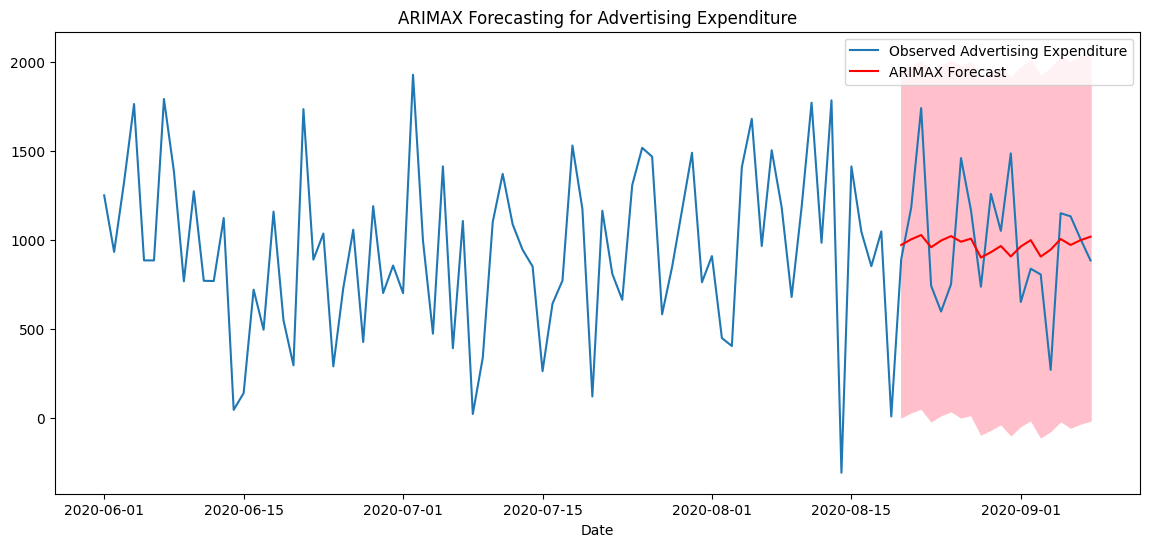

In [21]:
# Plot ARIMAX forecast
plt.figure(figsize=(14, 6))
plt.plot(data['advertising_expenditure'], label='Observed Advertising Expenditure')
plt.plot(arimax_forecast_mean, color='red', label='ARIMAX Forecast')
plt.fill_between(arimax_conf_int.index,
                 arimax_conf_int.iloc[:, 0],
                 arimax_conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.title('ARIMAX Forecasting for Advertising Expenditure')
plt.xlabel('Date')
plt.show()


## 4.2 SARIMAX
**SARIMAX** stands for Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables, an extension of the ARIMA model that incorporates both seasonal components and external (exogenous) factors to improve forecasting accuracy. It is used for modeling time series data that exhibit both seasonality and external influences impacting future values of the primary series.

**Key Components of SARIMAX:** <br>
* <u>p (AutoRegressive part):</u> The number of lag observations of the primary series.
* <u>d (Integrated part):</u> The number of differencing steps needed to make the primary series stationary.
* <u>q (Moving Average part):</u> The number of lagged forecast errors included.
* **Seasonal Components:**
    * <u> P (Seasonal AutoRegressive part):</u> The number of seasonal lag observations.
    * <u> D (Seasonal Differencing part):</u> The number of seasonal differencing steps required.
    * <u> Q (Seasonal Moving Average part):</u> The number of lagged seasonal forecast errors included.
    * <u> m (Seasonal Period):</u> The number of time periods in a season (e.g., 12 for monthly data with yearly seasonality).
    * <u> Exogenous Variables:</u> In addition to the seasonal ARIMA components, SARIMAX includes one or more exogenous variables (independent predictors) that influence the primary series, allowing the model to account for external factors outside the series itself, as well as seasonal effects within the data.

In [22]:
# Define the p, d, q parameters for the regular ARIMA part
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Define the P, D, Q parameters for the seasonal part and try two seasonal periods
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
seasonal_periods = [12]

# DataFrame to store results
results = []

# Grid search over SARIMAX parameters with multiple seasonal periods
for param in pdq:
    for seasonal_m in seasonal_periods:
        seasonal_pdq = [(x[0], x[1], x[2], seasonal_m) for x in itertools.product(P, D, Q)]
        for seasonal_param in seasonal_pdq:
            try:
                # Fit SARIMAX model with exogenous variable(s) (e.g., exog=train_exog)
                temp_model = SARIMAX(train_data['advertising_expenditure'],
                                     order=param,
                                     seasonal_order=seasonal_param,
                                     exog=train_exog)
                temp_result = temp_model.fit(disp=False)  # disp=False suppresses output

                # Store parameters and AIC
                results.append([param, seasonal_param, temp_result.aic])
            except Exception as e:
                continue

# Convert results to DataFrame and sort by AIC
results_df = pd.DataFrame(results, columns=['SARIMAX parameters', 'Seasonal parameters', 'AIC'])
results_df = results_df.sort_values(by='AIC').reset_index(drop=True)

print("Optimal SARIMAX parameters and AIC values:")
print(results_df)

Optimal SARIMAX parameters and AIC values:
    SARIMAX parameters Seasonal parameters          AIC
0            (0, 2, 1)       (2, 0, 1, 12)    12.000000
1            (2, 0, 1)       (2, 0, 1, 12)    16.000000
2            (1, 2, 2)       (0, 1, 1, 12)  1044.126550
3            (0, 2, 2)       (0, 1, 2, 12)  1044.484476
4            (0, 2, 2)       (0, 1, 1, 12)  1045.453688
..                 ...                 ...          ...
478          (0, 2, 0)       (1, 0, 1, 12)  1331.398522
479          (0, 2, 0)       (1, 0, 2, 12)  1331.401885
480          (0, 2, 0)       (2, 0, 2, 12)  1335.013703
481          (0, 2, 0)       (0, 0, 2, 12)  1335.940087
482          (0, 0, 0)       (0, 0, 0, 12)  1344.354247

[483 rows x 3 columns]


In [23]:
# Define the SARIMAX parameters
order = (1, 2, 2)
seasonal_order = (0, 1, 1, 12)

# Fit the SARIMAX model with exogenous variables if available (e.g., exog=train_exog)
sarimax_model = SARIMAX(train_data['advertising_expenditure'], order=order, seasonal_order=seasonal_order, exog=train_exog)
sarimax_fit = sarimax_model.fit()

# Print the summary of the fitted model
print(sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:              advertising_expenditure   No. Observations:                   80
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -516.063
Date:                              Thu, 07 Nov 2024   AIC                           1044.127
Time:                                      10:40:16   BIC                           1057.264
Sample:                                  06-01-2020   HQIC                          1049.318
                                       - 08-19-2020                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
market_gain    -0.5380      0.624     -0.862      0.389      -1.762       0.686
ar.L1          -

In [24]:
# Forecasting with SARIMAX
sarimax_forecast = sarimax_fit.get_forecast(steps=forecast_steps, exog=test_exog)
sarimax_forecast_mean = sarimax_forecast.predicted_mean
sarimax_conf_int = sarimax_forecast.conf_int()

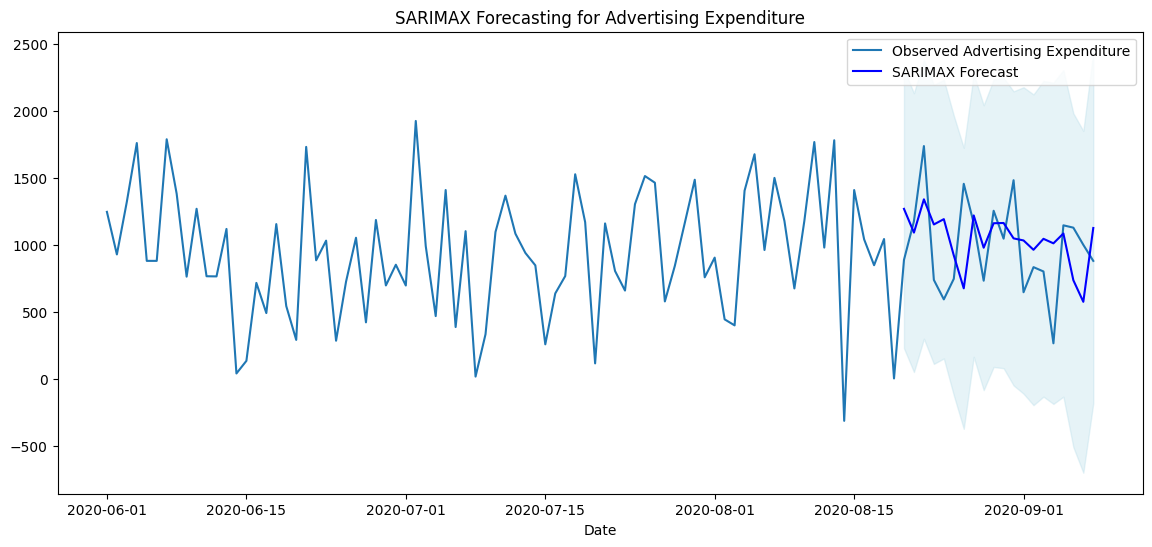

In [25]:
# Plot SARIMAX forecast
plt.figure(figsize=(14, 6))
plt.plot(data['advertising_expenditure'], label='Observed Advertising Expenditure')
plt.plot(sarimax_forecast_mean, color='blue', label='SARIMAX Forecast')
plt.fill_between(sarimax_conf_int.index,
                 sarimax_conf_int.iloc[:, 0],
                 sarimax_conf_int.iloc[:, 1], color='lightblue', alpha=0.3)
plt.legend()
plt.title('SARIMAX Forecasting for Advertising Expenditure')
plt.xlabel('Date')
plt.show()